# Example Notebook showcasing the different segmentation workflows

This notebook walks you through the different segmentation workflows currently implemented in SPARCSpy using the same input example. Each segmentation workflow needs to be implemented in a seperate SPARCSpy project as the segmentation mask is the starting point for all further downstream steps.


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import numpy as np
import tifffile

from sparcscore.pipeline.project import Project
from sparcscore.pipeline.extraction import HDF5CellExtraction

In [2]:
#define input images
project_directory = "../../../example_data/example_3/segmentation_workflows"

images = ["../../../example_data/example_3/input_images/Ch1.tif",
          "../../../example_data/example_3/input_images/Ch2.tif",
          "../../../example_data/example_3/input_images/Ch3.tif"]

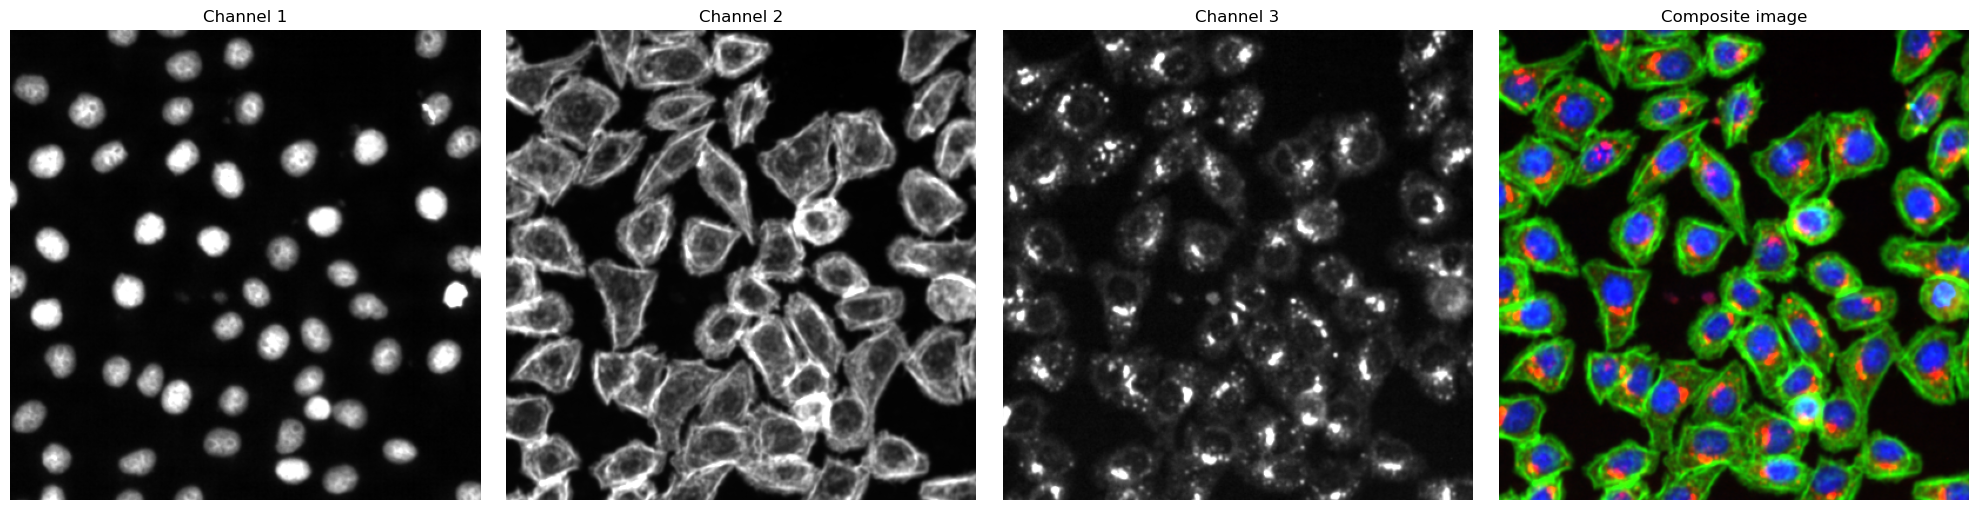

In [3]:
# visualize input images as example
# it is not recommended to execute this block with large input images as it will compute for some time

#read input image to visualize as an example
image = np.array([tifffile.imread(img) for img in images])

def colorize(im, color, clip_percentile=0.0):
    """
    Helper function to create an RGB image from a single-channel image using a
    specific color.
    """
    # Check that we do just have a 2D image
    if im.ndim > 2 and im.shape[2] != 1:
        raise ValueError('This function expects a single-channel image!')

    # Rescale the image according to how we want to display it
    im_scaled = im.astype(np.float32) - np.percentile(im, clip_percentile)
    im_scaled = im_scaled / np.percentile(im_scaled, 100 - clip_percentile)
    im_scaled = np.clip(im_scaled, 0, 1)

    # Need to make sure we have a channels dimension for the multiplication to work
    im_scaled = np.atleast_3d(im_scaled)

    # Reshape the color (here, we assume channels last)
    color = np.asarray(color).reshape((1, 1, -1))
    return im_scaled * color

def generate_composite(images, colors = [(0, 0, 1),(0, 1, 0), (1, 0, 0), (1, 0, 1)], plot = False):
    colorized = []
    for image, color in zip(images, colors):
        image = colorize(image, color, 0.0)
        colorized.append(image)

    if plot:
        for i in colorized:
            plt.figure()
            plt.imshow(i)

    image = colorized[0]
    for i in range(len(colorized)-1):
        image += colorized[i+1]

    return(np.clip(image, 0, 1))

fig, axs = plt.subplots(1, 4, figsize = (20, 5));

for i, _img in enumerate(image):
    axs[i].imshow(_img, cmap='gray')
    axs[i].axis("off")
    axs[i].set_title("Channel {}".format(i+1))

#also plot and visualize input image
img = generate_composite(image)

axs[3].imshow(img)
axs[3].axis("off");
axs[3].set_title("Composite image");

fig.tight_layout()

## WGA Segmentation

This segmentation workflow aims to segment mononucleated cells. Based on a nuclear and cytosolic stain, it first uses a thresholding approach to identify nuclei which are assumed to be the center of each cell. Then in a second step, the center of the identified nuclei are used as a starting point to generate a potential map using the cytosolic stain. This potential map is then used to segment the cytosol using a watershed approach. At the end of the workflow the user obtains both a nuclear and a cytosolic segmentation mask where each cytosol is matched to exactly one nucleus as kann be identified by the matching ``cell id``. 

The configuration file for the WGASegmentation method contains many parameters that need to be optimized for your particular dataset. Here is an example configuration:

    WGASegmentation:
        input_channels: 3
        chunk_size: 50 # chunk size for chunked HDF5 storage. is needed for correct caching and high performance reading. should be left at 50.
        lower_quantile_normalization:   0.001
        upper_quantile_normalization:   0.999
        median_filter_size:   4 # Size in pixels
        nucleus_segmentation:
            lower_quantile_normalization:   0.01 # quantile normalization of dapi channel before local tresholding. Strong normalization (0.05,0.95) can help with nuclear speckles.
            upper_quantile_normalization:   0.99 # quantile normalization of dapi channel before local tresholding. Strong normalization (0.05,0.95) can help with nuclear speckles.
            median_block: 41 # Size of pixel disk used for median, should be uneven
            median_step: 4
            threshold: 0.2 # threshold above local median for nuclear segmentation
            min_distance: 8 # minimum distance between two nucleis in pixel
            peak_footprint: 7 # 
            speckle_kernel: 9 # Erosion followed by Dilation to remove speckels, size in pixels, should be uneven
            dilation: 0 # final dilation of pixel mask       
            min_size: 200 # minimum nucleus area in pixel
            max_size: 5000 # maximum nucleus area in pixel
            contact_filter: 0.5 # minimum nucleus contact with background
        wga_segmentation:
            threshold: 0.05 # treshold above which cytosol is detected
            lower_quantile_normalization: 0.01
            upper_quantile_normalization: 0.99
            erosion: 2 # erosion and dilation are used for speckle removal and shrinking / dilation
            dilation: 7 # for no change in size choose erosion = dilation, for larger cells increase the mask erosion
            min_clip: 0
            max_clip: 0.2
            min_size: 200
            max_size: 30000
        chunk_size: 50

In [4]:
from sparcscore.pipeline.workflows import WGASegmentation

project_location = f"{project_directory}/WGASegmentation"

project = Project(os.path.abspath(project_location),
                  config_path= "../../../example_data/example_3/config_example3.yml",
                  overwrite=True,
                  debug=False,
                  segmentation_f=WGASegmentation,
                  extraction_f=HDF5CellExtraction,
                  )

project.load_input_from_file(images)

modifying config


/Users/sophia/Documents/GitHub/SPARCSspatial/src/sparcscore/pipeline/project.py:152: UserWarning: There is already a directory in the location path
  warnings.warn("There is already a directory in the location path")


In [5]:
project.segment(debug=False)
project.extract()

/Users/sophia/Documents/GitHub/SPARCSspatial/src/sparcscore/pipeline/workflows.py:271: RuntimeWarning: invalid value encountered in cast
  px_center = np.round(center_nuclei).astype(np.uint64)
/Users/sophia/Documents/GitHub/SPARCSspatial/src/sparcscore/pipeline/workflows.py:293: RuntimeWarning: invalid value encountered in cast
  px_center = np.round(center_nuclei).astype(np.uint64)


Processing cell batches:   0%|          | 0/49 [00:00<?, ?it/s]

multiprocessing done.


### Segmentation Results

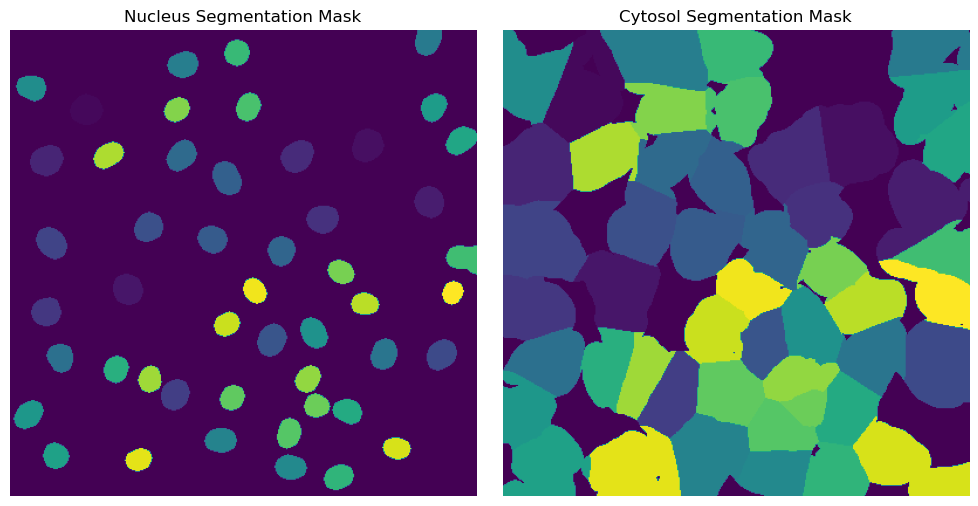

In [6]:
with h5py.File(f"{project_location}/segmentation/segmentation.h5") as hf:
    segmentation = hf.get("labels")

    fig, axs = plt.subplots(1, 2, figsize = (10, 5));
    axs[0].imshow(segmentation[0])
    axs[0].axis("off")
    axs[0].set_title("Nucleus Segmentation Mask")

    axs[1].imshow(segmentation[1])
    axs[1].axis("off")
    axs[1].set_title("Cytosol Segmentation Mask")
    fig.tight_layout()

### Extraction Results

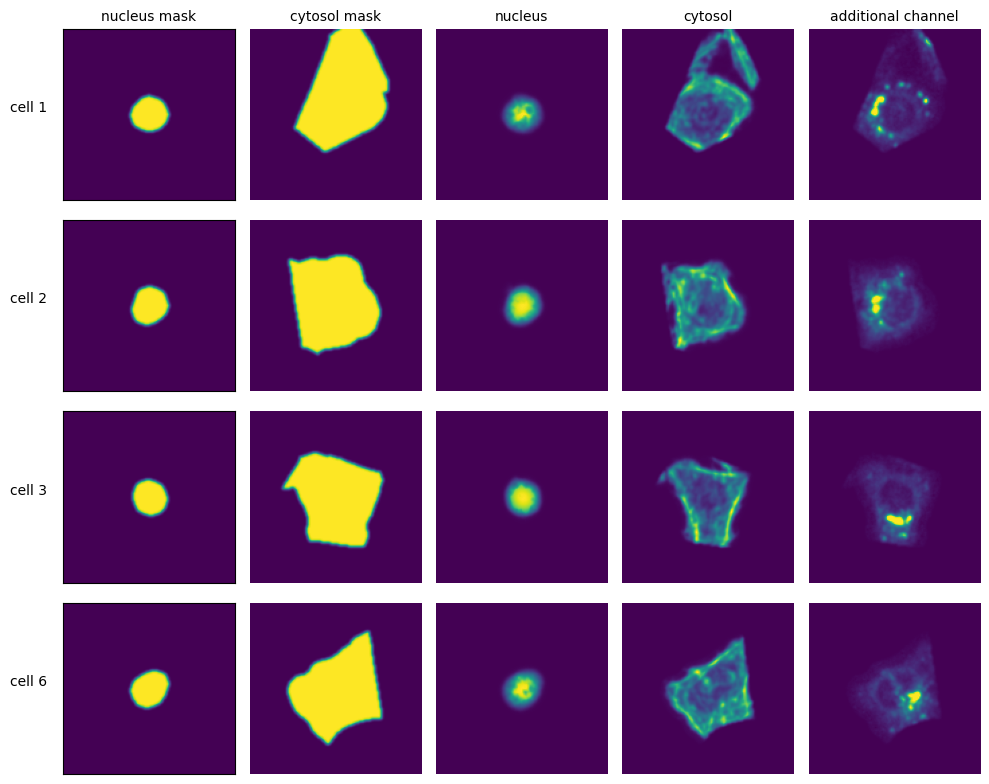

In [7]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    _images = hf.get("single_cell_data")

    n_cells = 4
    fig, axs = plt.subplots(n_cells, 5, figsize = (5*2, n_cells*2))
    labels = ["nucleus mask", "cytosol mask", "nucleus", "cytosol", "additional channel"]
    
    for i in range(n_cells):
        cell_id = index[i][1]
        image = _images[i]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize = 10, rotation = 0, labelpad = 25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")
        
            if i == 0:
                axs[i, n].set_title(labels[n], fontsize = 10)
            
            
    fig.tight_layout()

## DAPI Segmentation

This segmentation workflow aims to only segment the nuclei of cells.

In [8]:
from sparcscore.pipeline.workflows import DAPISegmentation

project_location = f"{project_directory}/DAPISegmentation"

project = Project(os.path.abspath(project_location),
                  config_path= "../../../example_data/example_3/config_example3.yml",
                  overwrite=True,
                  debug=False,
                  segmentation_f=DAPISegmentation,
                  extraction_f=HDF5CellExtraction,
                  )

project.load_input_from_file(images)

modifying config


/Users/sophia/Documents/GitHub/SPARCSspatial/src/sparcscore/pipeline/project.py:152: UserWarning: There is already a directory in the location path
  warnings.warn("There is already a directory in the location path")


In [9]:
project.segment()
project.extract()

Processing cell batches:   0%|          | 0/49 [00:00<?, ?it/s]

multiprocessing done.


In [10]:
project.segmentation_f.maps

{'normalized': array([[[1.49588929e-02, 1.32301599e-02, 8.65590200e-03, ...,
          5.82567602e-03, 1.07976953e-02, 1.33066522e-02],
         [1.40562803e-02, 1.13025466e-02, 7.82978255e-03, ...,
          5.68798929e-03, 1.00327693e-02, 1.22051593e-02],
         [1.22816516e-02, 1.03999339e-02, 1.09659787e-02, ...,
          8.59470852e-03, 9.86448582e-03, 1.20215770e-02],
         ...,
         [1.88906137e-02, 1.93648674e-02, 2.54383795e-02, ...,
          8.32221150e-01, 8.45653236e-01, 8.21986437e-01],
         [2.44592745e-02, 2.14607641e-02, 2.83450987e-02, ...,
          8.86056602e-01, 8.58152151e-01, 8.04393113e-01],
         [2.54536774e-02, 2.22562868e-02, 2.87581589e-02, ...,
          8.98326039e-01, 8.25535655e-01, 7.59430766e-01]],
 
        [[2.00327531e-01, 1.65171877e-01, 1.09936021e-01, ...,
          1.29633602e-02, 1.01472344e-02, 1.08818756e-02],
         [2.60843605e-01, 2.14744866e-01, 1.53371692e-01, ...,
          2.23912578e-02, 1.49683189e-02, 1.42336776

### Segmentation Results

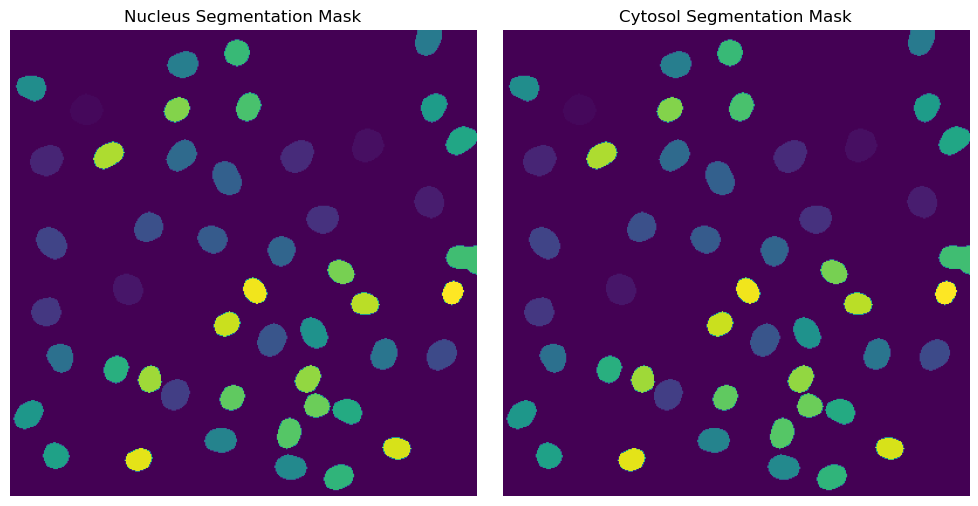

In [11]:
with h5py.File(f"{project_location}/segmentation/segmentation.h5") as hf:
    segmentation = hf.get("labels")

    fig, axs = plt.subplots(1, 2, figsize = (10, 5));
    axs[0].imshow(segmentation[0])
    axs[0].axis("off")
    axs[0].set_title("Nucleus Segmentation Mask")

    axs[1].imshow(segmentation[1])
    axs[1].axis("off")
    axs[1].set_title("Cytosol Segmentation Mask")
    fig.tight_layout()

### Extraction Results

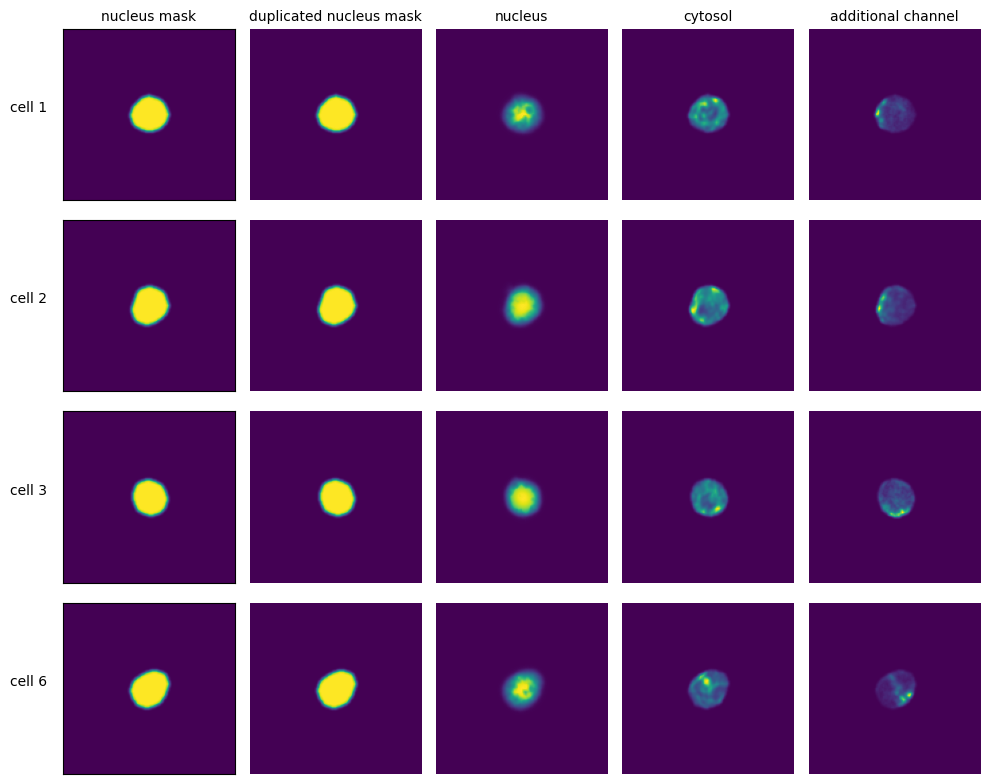

In [12]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    _images = hf.get("single_cell_data")

    n_cells = 4
    fig, axs = plt.subplots(n_cells, 5, figsize = (5*2, n_cells*2))
    labels = ["nucleus mask", "duplicated nucleus mask", "nucleus", "cytosol", "additional channel"]
    
    for i in range(n_cells):
        cell_id = index[i][1]
        image = _images[i]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize = 10, rotation = 0, labelpad = 25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")
        
            if i == 0:
                axs[i, n].set_title(labels[n], fontsize = 10)
            
            
    fig.tight_layout()

## Cytosol Segmentation Cellpose

This method uses a deep learning based segmentation approach and should optimally be run using a GPU as it is otherwise very slow.

In [13]:
from sparcscore.pipeline.workflows import CytosolSegmentationCellpose

project_location = f"{project_directory}/CytosolSegmentationCellpose"

project = Project(os.path.abspath(project_location),
                  config_path= "../../../example_data/example_3/config_example3.yml",
                  overwrite=True,
                  debug=False,
                  segmentation_f=CytosolSegmentationCellpose,
                  extraction_f=HDF5CellExtraction,
                  )

project.load_input_from_file(images)

modifying config


/Users/sophia/Documents/GitHub/SPARCSspatial/src/sparcscore/pipeline/project.py:152: UserWarning: There is already a directory in the location path
  warnings.warn("There is already a directory in the location path")


In [14]:
project.segment()
project.extract()

/Users/sophia/Documents/GitHub/SPARCSspatial/src/sparcscore/pipeline/extraction.py:652: RuntimeWarning: invalid value encountered in cast
  px_centers = np.round(center_nuclei).astype(int)


Processing cell batches:   0%|          | 0/49 [00:00<?, ?it/s]

multiprocessing done.


### Segmentation Results

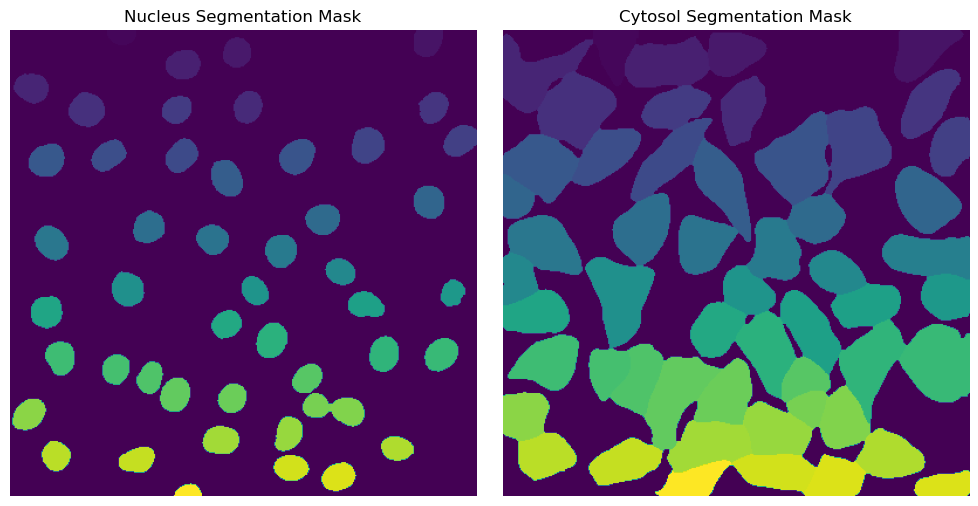

In [15]:
with h5py.File(f"{project_location}/segmentation/segmentation.h5") as hf:
    segmentation = hf.get("labels")

    fig, axs = plt.subplots(1, 2, figsize = (10, 5));
    axs[0].imshow(segmentation[0])
    axs[0].axis("off")
    axs[0].set_title("Nucleus Segmentation Mask")

    axs[1].imshow(segmentation[1])
    axs[1].axis("off")
    axs[1].set_title("Cytosol Segmentation Mask")
    fig.tight_layout()

### Extraction Results

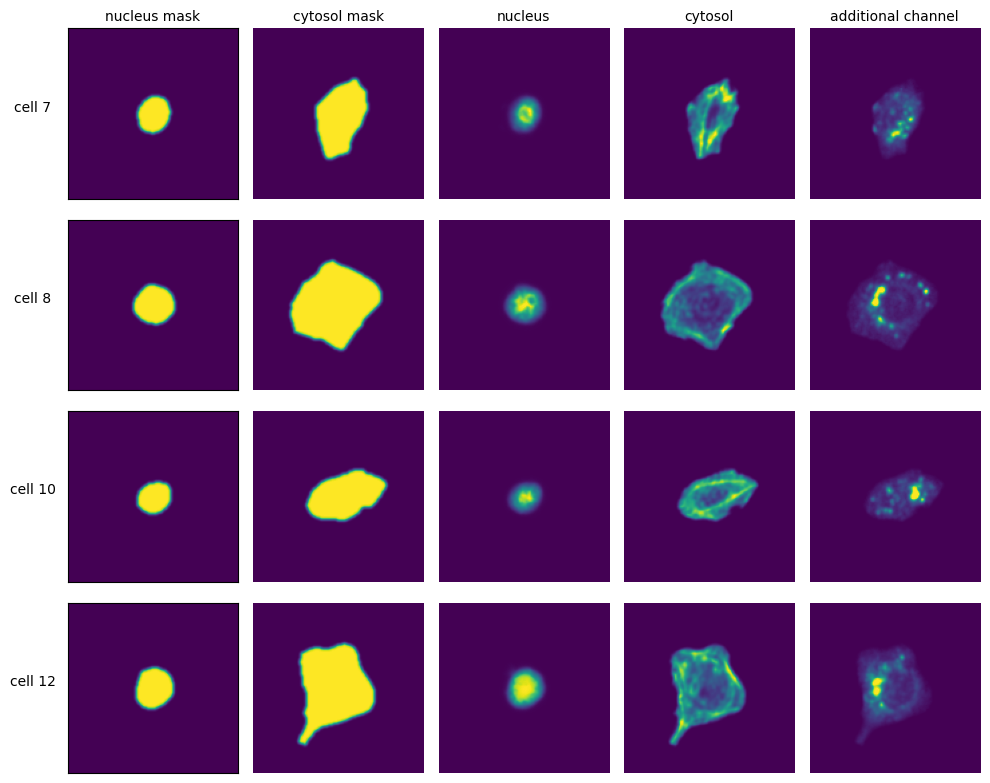

In [16]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    _images = hf.get("single_cell_data")

    n_cells = 4
    fig, axs = plt.subplots(n_cells, 5, figsize = (5*2, n_cells*2))
    labels = ["nucleus mask", "cytosol mask", "nucleus", "cytosol", "additional channel"]
    
    for i in range(n_cells):
        cell_id = index[i][1]
        image = _images[i]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize = 10, rotation = 0, labelpad = 25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")
        
            if i == 0:
                axs[i, n].set_title(labels[n], fontsize = 10)
            
            
    fig.tight_layout()

## DAPI Segmentation Cellpose

This method uses a deep learning based segmentation approach and should optimally be run using a GPU as it is otherwise very slow.

In [17]:
from sparcscore.pipeline.workflows import DAPISegmentationCellpose

project_location = f"{project_directory}/DAPISegmentationCellpose"

project = Project(os.path.abspath(project_location),
                  config_path= "../../../example_data/example_3/config_example3.yml",
                  overwrite=True,
                  debug=False,
                  segmentation_f=DAPISegmentationCellpose,
                  extraction_f=HDF5CellExtraction,
                  )

project.load_input_from_file(images)

modifying config


/Users/sophia/Documents/GitHub/SPARCSspatial/src/sparcscore/pipeline/project.py:152: UserWarning: There is already a directory in the location path
  warnings.warn("There is already a directory in the location path")


In [18]:
project.segment()
project.extract()

Processing cell batches:   0%|          | 0/59 [00:00<?, ?it/s]

multiprocessing done.


### Segmentation Results

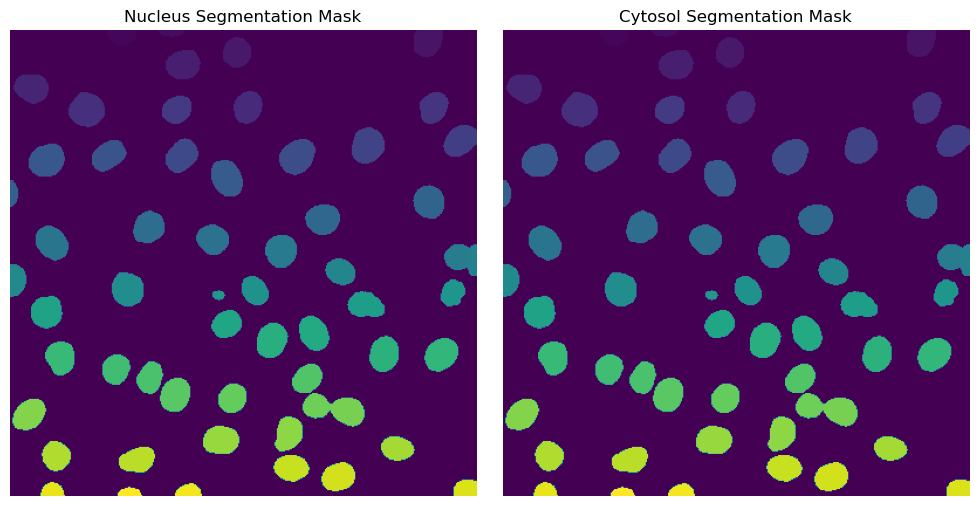

In [19]:
with h5py.File(f"{project_location}/segmentation/segmentation.h5") as hf:
    segmentation = hf.get("labels")

    fig, axs = plt.subplots(1, 2, figsize = (10, 5));
    axs[0].imshow(segmentation[0])
    axs[0].axis("off")
    axs[0].set_title("Nucleus Segmentation Mask")

    axs[1].imshow(segmentation[1])
    axs[1].axis("off")
    axs[1].set_title("Cytosol Segmentation Mask")
    fig.tight_layout()

### Extraction Results

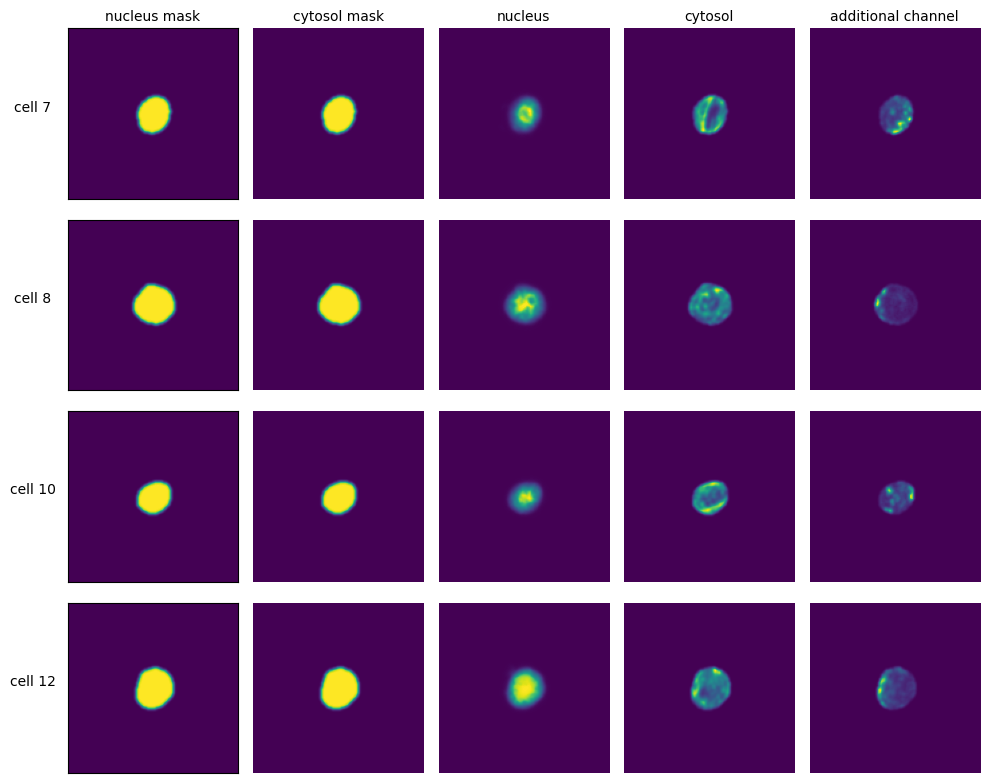

In [20]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    images = hf.get("single_cell_data")

    n_cells = 4
    fig, axs = plt.subplots(n_cells, 5, figsize = (5*2, n_cells*2))
    labels = ["nucleus mask", "cytosol mask", "nucleus", "cytosol", "additional channel"]
    
    for i in range(n_cells):
        cell_id = index[i][1]
        image = images[i]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize = 10, rotation = 0, labelpad = 25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")
        
            if i == 0:
                axs[i, n].set_title(labels[n], fontsize = 10)
            
            
    fig.tight_layout()